Number of keypoints in left image: 509
Number of keypoints in right image: 532
Number of good matches found: 14


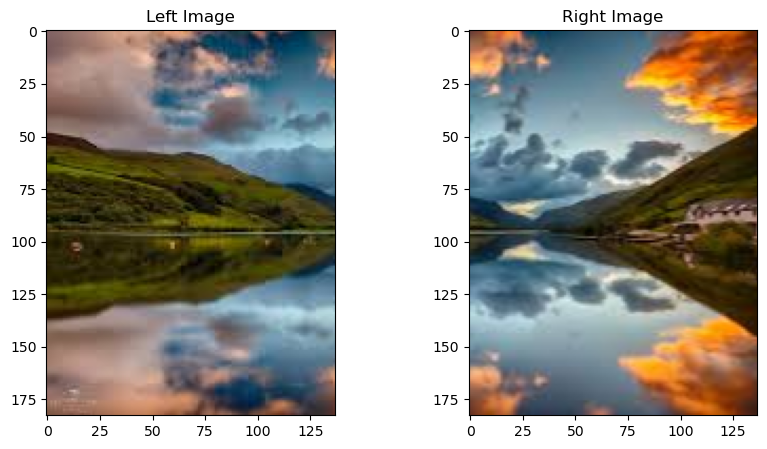

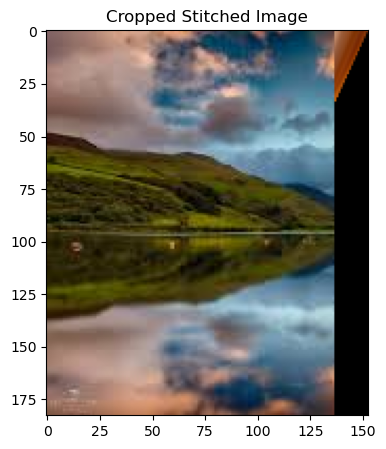

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img_left = cv2.imread('./left.jpg')
img_right = cv2.imread('./right.jpg')

# Verify images are loaded
if img_left is None or img_right is None:
    raise ValueError("Could not load images. Check file paths.")

# Resize images if they're too large (helps with feature matching)
max_dimension = 800
scale_left = max_dimension / max(img_left.shape[:2])
scale_right = max_dimension / max(img_right.shape[:2])

if scale_left < 1:
    img_left = cv2.resize(img_left, None, fx=scale_left, fy=scale_left)
if scale_right < 1:
    img_right = cv2.resize(img_right, None, fx=scale_right, fy=scale_right)

# Convert to grayscale
img1 = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

# Optional: Apply contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img1 = clahe.apply(img1)
img2 = clahe.apply(img2)

# Initialize the SIFT detector with more relaxed parameters
sift = cv2.SIFT_create(
    nfeatures=0,  # no limit on number of features
    nOctaveLayers=5,
    contrastThreshold=0.02,  # Lower threshold to detect more features
    edgeThreshold=20,
    sigma=1.6
)

# Detect the keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

print(f"Number of keypoints in left image: {len(kp1)}")
print(f"Number of keypoints in right image: {len(kp2)}")

# Create FLANN matcher (faster and better than BFMatcher for SIFT)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Find matches
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test with more relaxed threshold
good = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:  # More relaxed ratio test
        good.append(m)

print(f"Number of good matches found: {len(good)}")

if len(good) > 4:  # Reduced minimum matches threshold
    # Get matching points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    
    # Compute Homography with more relaxed RANSAC parameters
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Calculate dimensions of combined image
    h, w = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, H)
    
    # Get offset for full image coverage
    dst = np.int32(dst)
    min_x = min(min(dst[x][0][0] for x in range(4)), 0)
    max_x = max(max(dst[x][0][0] for x in range(4)), w2)
    min_y = min(min(dst[x][0][1] for x in range(4)), 0)
    max_y = max(max(dst[x][0][1] for x in range(4)), h2)
    
    # Adjust transformation matrix
    offset_x = -min_x if min_x < 0 else 0
    offset_y = -min_y if min_y < 0 else 0
    H_adjusted = np.array([[1, 0, offset_x], [0, 1, offset_y], [0, 0, 1]]) @ H
    
    # Create output image with adjusted size
    output_width = max_x + offset_x
    output_height = max_y + offset_y
    output_img = cv2.warpPerspective(img_left, H_adjusted, (output_width, output_height))
    
    # Create a mask for blending
    mask = np.zeros((output_height, output_width), dtype=np.uint8)
    mask[offset_y:h2+offset_y, offset_x:w2+offset_x] = 255
    
    # Copy the second image with blending
    for y in range(offset_y, min(h2 + offset_y, output_height)):
        for x in range(offset_x, min(w2 + offset_x, output_width)):
            if mask[y, x] == 255:
                output_img[y, x] = img_right[y - offset_y, x - offset_x]
    
    # Convert to grayscale and create mask for finding bounds
    gray = cv2.cvtColor(output_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    
    # Find contours and crop to content
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(max_contour)
        cropped_stitched = output_img[y:y+h, x:x+w]
        
    # Display the two original images
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img_left_rgb)
        plt.title('Left Image')
        plt.subplot(1, 2, 2)
        plt.imshow(img_right_rgb)
        plt.title('Right Image')
 
     # Display the stitched image
     # Bug fix 3: Fixed variable name typo 'cropped_stitched_rgb' was misspelled
        plt.figure(figsize=(20, 5))
        plt.imshow(cropped_stitched_rgb)
        plt.title('Cropped Stitched Image')
     # Bug fix 4: Added parentheses to actually call the show method
        plt.show()
        
        # Save the result
        cv2.imwrite('improved_stitched_output.jpg', cropped_stitched)
else:
    # Visualize keypoints to debug
    img_left_kp = cv2.drawKeypoints(img_left, kp1, None, color=(0,255,0))
    img_right_kp = cv2.drawKeypoints(img_right, kp2, None, color=(0,255,0))
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img_left_kp, cv2.COLOR_BGR2RGB))
    plt.title(f'Left Image Keypoints: {len(kp1)}')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img_right_kp, cv2.COLOR_BGR2RGB))
    plt.title(f'Right Image Keypoints: {len(kp2)}')
    plt.show()
    
    raise AssertionError(f"Not enough good matches found - {len(good)}/4")